In [1]:
import matplotlib.pyplot as plt
import graph_tool.all as gt
import numpy as np
import pandas as pd

In [3]:
edge_list = pd.read_parquet('./parquets/rns_contacts_full_1.parquet', columns=['p_A', 'p_B', 'start_of_contact', 'end_of_contact']).values

In [18]:
df = pd.read_parquet('./VF_data/rns_data.parquet')

In [29]:
df.p_group.values

array([4, 4, 4, ..., 1, 1, 1], dtype=int8)

In [32]:
arr = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
arr[[1, 1, 2, 3, 7]] = [10, 10, 2, 43, 22]
arr

array([ 0, 10,  2, 43,  0,  0,  0, 22,  0,  0])

In [30]:
arr = np.zeros(df.p_id.max() + 1).astype('int8')
arr[df.p_id.values] = df.p_group.values
arr

array([ 4., 10.,  1., ...,  1.,  1.,  1.])

In [31]:
df.groupby('p_id')['p_group'].first().values

array([ 4, 10,  1, ...,  1,  1,  1], dtype=int8)

In [2]:
def full_network_generation(edge_path='./parquets/rns_contacts_full_1.parquet'):
    # It's faster to create a new Graph from the edges contained in the parquet file,
    # than to save the graph as a gt-file and reloade it.

    print('Load parquet file')
    edge_list = pd.read_parquet(edge_path).values
    df = pd.read_parquet('./VF_data/rns_data.parquet')
    p_group = np.zeros(df.p_id.max() + 1).astype('int8')
    p_group[df.p_id.values] = df.p_group.values
    
    G = gt.Graph(directed=False)
    print(f'Add {len(p_group)} vertices')
    G.add_vertex(len(p_group))
    p_group_prop = G.new_vp('short', vals=p_group)
    G.vp['p_group'] = p_group_prop

    print('Add edges')
    G.add_edge_list(edge_list, eprops=[('start_time', 'int16_t'), ('end_time', 'int16_t')])

    duration_prop = G.new_ep('int16_t')
    duration_prop.a = G.ep.end_time.a - G.ep.start_time.a
    G.ep['duration'] = duration_prop

    return G

G = full_network_generation()

Load parquet file
Add 2551684 vertices
Add edges


In [3]:
# Handle paralelization
gt.openmp_enabled()
gt.openmp_set_num_threads(25)

# Degree distribution

In [141]:
counts_w, bins_w = gt.vertex_hist(G, G.degree_property_map('out', G.ep.duration), [0, 10])
bins_w = bins_w[1:]
counts_w = counts_w/np.sum(counts_w)
bins_w = bins_w / bins_w.max()

counts, bins = gt.vertex_hist(G, 'out', [0, 10])
bins = bins[1:]
counts = counts/np.sum(counts)
bins = bins / bins.max()

In [153]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
ax1, ax2 = axs.flatten()

ax1.grid()
ax1.scatter(bins_w, counts_w, alpha=.1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$k_{out} / k_{out, max}$')
ax1.set_ylabel(r'$p(k_{out})$')
ax1.set_title('weighted degree distribution of rns network')

ax2.grid()
ax2.scatter(bins, counts, alpha=.1)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r'$k_{out} / k_{out, max}$')
ax2.set_ylabel(r'$p(k_{out})$')
ax2.set_title('degree distribution of rns network')

plt.tight_layout()
plt.savefig('degree_out_dist_full_weighted_rns.png')
plt.close()

# Distance distribution

In [4]:
n_samples = 1_000
counts_dist, bins_dist = gt.distance_histogram(G, samples=n_samples)

In [5]:
bins_dist = bins_dist[1:]

In [7]:
plt.scatter(bins_dist, counts_dist/np.sum(counts_dist), alpha=.8)
#plt.xlim((0, 20))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$d$')
plt.ylabel(r'$p(d)$')
plt.title(f'Shortest path distribution of VF data ({n_samples} samples)')
plt.tight_layout()
plt.savefig(f'shortest_path_dist_full_{n_samples}_rns.png')
plt.close()

# Generate Ego Network

In [88]:
def get_ego_network(G, source_vertex, depth):
    dist = gt.shortest_distance(G, source_vertex, max_dist=depth) 
    G.vp['depth'] = dist
    u = gt.GraphView(G, vfilt=dist.a <= depth) 
    return u

G_ego = get_ego_network(G, 1, 1)
print(G_ego.num_edges(), G_ego.num_vertices())

1998 86


In [89]:
spring_pos = gt.sfdp_layout(G_ego, verbose=True)

1 4.18609e+07 9.91564 9.91564 15 12.8605
2 7.70802e+07 9.41986 9.41986 15 11.1163
3 5.06393e+08 8.94886 8.94886 15 10.8837
4 5.63573e+07 8.50142 8.50142 15 10.5116
5 3.88751e+07 8.50142 8.50142 15 9.18605
6 4.28071e+07 8.50142 8.50142 15 8.47674
7 5.28847e+07 8.07635 8.07635 15 9.23256
8 3.99849e+07 7.67253 7.67253 15 8.27907
9 1.2562e+09 7.67253 7.67253 15 10.0465
10 6.13976e+07 7.2889 7.2889 15 9.38372
11 4.3464e+08 7.2889 7.2889 15 9.74419
12 4.3632e+07 6.92446 6.92446 15 8.76744
13 2.05164e+08 6.92446 6.92446 15 9.86047
14 2.44136e+07 6.57824 6.57824 15 9.56977
15 1.04413e+07 6.57824 6.57824 15 8.73256
16 2.16284e+07 6.57824 6.57824 15 8.30233
17 3.95456e+08 6.24932 6.24932 15 8.05814
18 1.67036e+07 5.93686 5.93686 15 10.5349
19 9.32106e+06 5.93686 5.93686 15 8.40698
20 1.27825e+07 5.93686 5.93686 15 9.54651
21 3.86262e+07 5.64002 5.64002 15 8.7907
22 1.02094e+07 5.35801 5.35801 15 8.96512
23 1.11075e+08 5.35801 5.35801 15 9.51163
24 2.76452e+07 5.09011 5.09011 15 10.093
25 5.71278

In [91]:
radial_pos = gt.radial_tree_layout(G_ego, root=1)

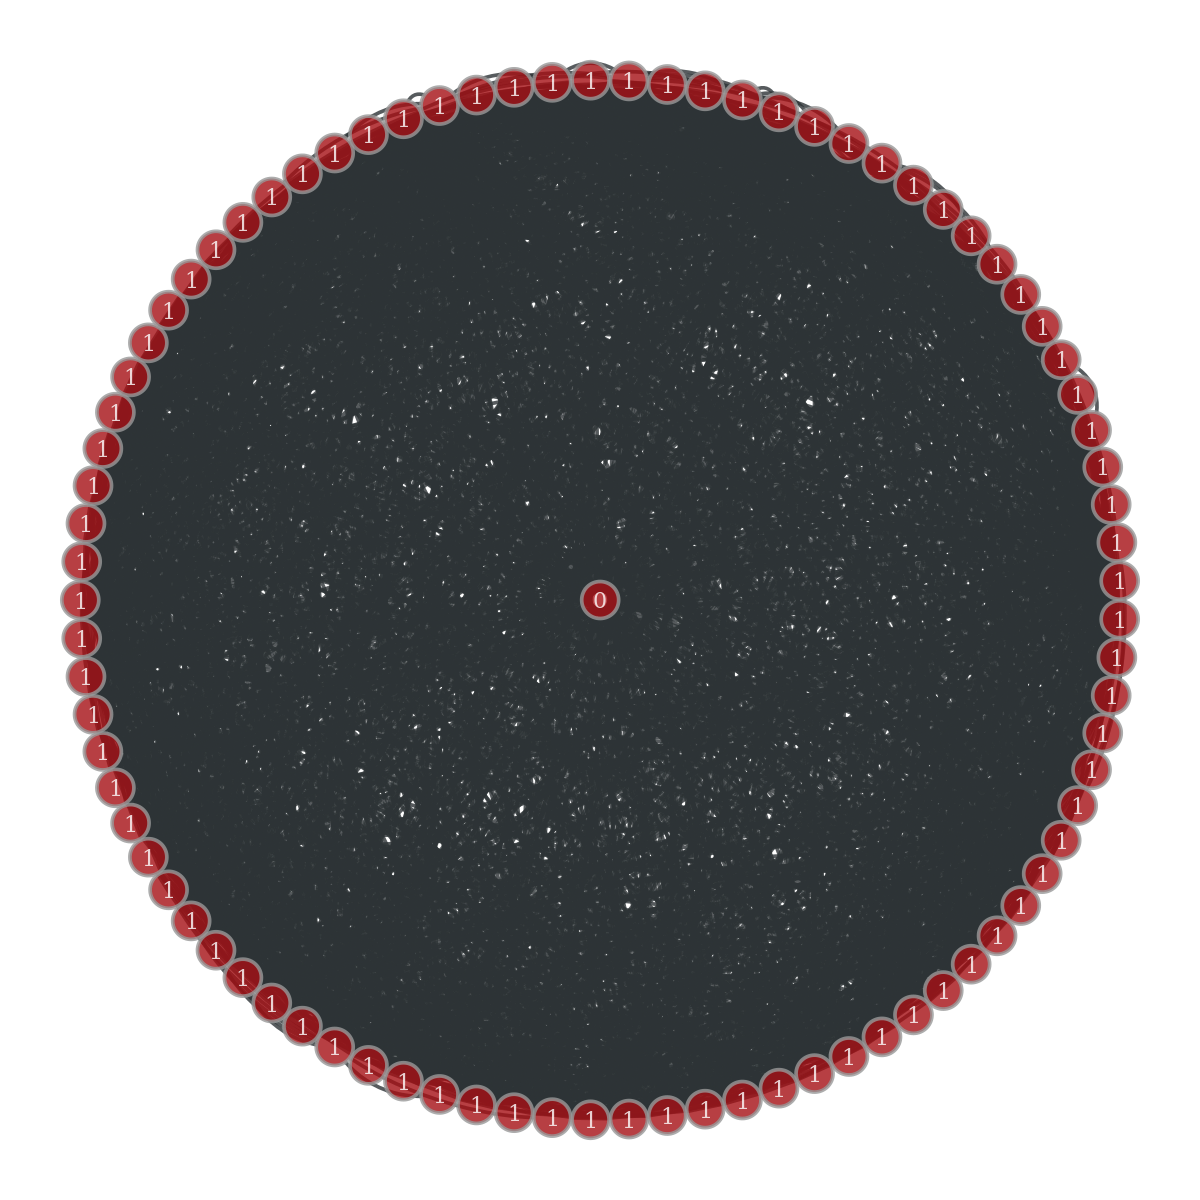

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3558231510, at 0x7f355a22abd0>

In [92]:
gt.graph_draw(G_ego, pos=radial_pos, vertex_text=G_ego.vp.depth)

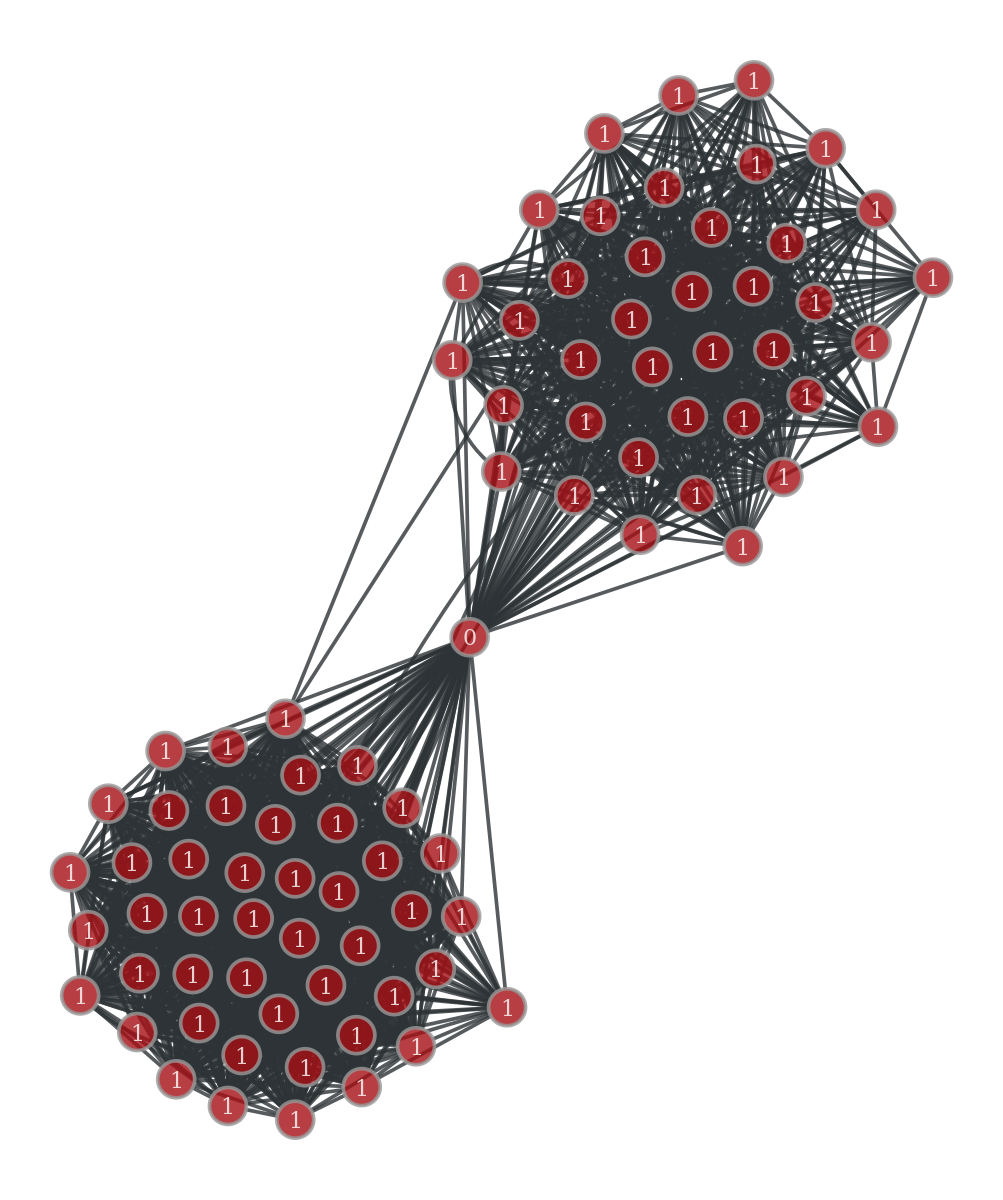

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3558231510, at 0x7f3558219250>

In [93]:
gt.graph_draw(G_ego, pos=spring_pos, vertex_text=G_ego.vp.depth)

In [30]:
def get_ego_network(G, source_vertex, depth):
    d = gt.shortest_distance(G, source_vertex, max_dist=depth) 
    u = gt.GraphView(G, vfilt=d.a <= depth) 

    return u

G_ego = get_ego_network(G, 100, 4)

In [31]:
G_ego.num_vertices() / G.num_vertices()

0.9423917695137799

In [32]:
counts, bins = gt.vertex_hist(G, 'out', [0, 1])
bins = (bins[1:] - bins[:-1]) / 2 + bins[:-1]
plt.scatter(bins, counts/np.sum(counts), alpha=.1)
#plt.ylim((0, 10_000))
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$k_{out}$')
plt.ylabel(r'$p(k_{out})$')
plt.title('Degree distribution of VF data')
plt.tight_layout()
plt.savefig('degree_out_dist_full_rns.png')
plt.close()

In [ ]:
counts, bins = gt.distance_histogram(G, samples=1000)
bins = (bins[1:] - bins[:-1]) / 2 + bins[:-1]

In [ ]:
print(np.argmax(counts))
print(bins)
bins = bins + .5

3
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5]


In [ ]:
print(bins.shape, counts.shape)
plt.scatter(bins, counts/np.sum(counts), alpha=.8)
plt.xlim((0, 20))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$d$')
plt.ylabel(r'$p(d)$')
plt.title('Shortest path distribution of VF data (1000 samples)')
plt.tight_layout()
plt.savefig('shortest_path_dist_full_rns.png')
plt.close()

(48,) (48,)
